# 3 Charge Selection

Success: uproot, vector, and awkward are loaded.
--- START OF H -> 4l ANALYSIS (Real Data) ---
Attempting to load a maximum of 100000 events per file...
Step 1: Raw Data read OK
Diagnostic: Read 100000 events. Number of Muons in the first event: 3
Step 2: Flatten OK
Step 3: ID OK
DEBUG: Type/Dtype of df['pt'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['eta'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['phi'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['mass'].values: <class 'numpy.ndarray'> / float64
Success: 235079 leptons loaded from DoubleMuon_B.
Step 1: Raw Data read OK
Diagnostic: Read 100000 events. Number of Muons in the first event: 3
Step 2: Flatten OK
Step 3: ID OK
DEBUG: Type/Dtype of df['pt'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['eta'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['phi'].values: <class 'numpy.ndarray'> / float64
DEBUG: Type/Dtype of df['mass']

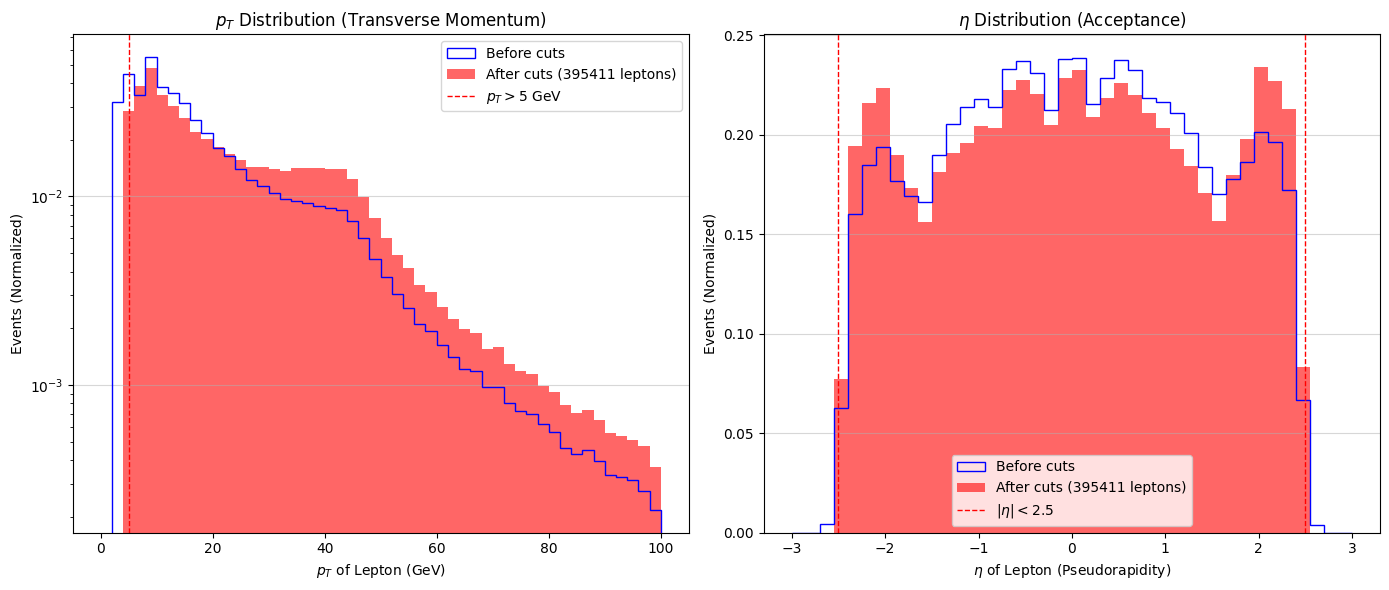


--- STATUS: Quality cuts applied and verified. ---

Preview of filtered leptons (ready for combination):
    event_id         pt  charge  flavor         iso
0  599701946  30.409157       1      13 -999.000000
1  599701946  33.029179       1      13 -999.000000
2  599721392  10.679796       1      13 -999.000000
3  599895577  56.900928       1      13    0.006498
4  599895577  34.670677      -1      13    0.000000


In [1]:
%run ../2_Leptons_Selection/main.ipynb

The code above allow use to execute the code of the notebook 2.

In [ ]:
def group_leptons_by_event_with_diagnostic_data(df):
    """
    Groups leptons by event, filtering to keep only events that meet the H -> 4l criteria
    (4 leptons, zero net charge) AND returns the 'Before Charge Cut' data for diagnostics.
    """
    print("\nStep 5: Applying event-level filtering (4 leptons and zero net charge)...")
    initial_events = df['event_id'].nunique()
    
    # CRITICAL STEP 1: TEMPORARILY REMOVE THE VECTOR COLUMN FOR SAFE FILTERING
    # We create a safe version of the DataFrame without the toxic 'lv' column
    
    kinematic_df = df.drop(columns=['lv']) if 'lv' in df.columns else df
    
    # 1. GROUP AND FILTER BASED ON BASE COLUMNS
    event_groups = kinematic_df.groupby('event_id')
    event_counts = event_groups.size()        # <-- DEFINED HERE
    event_net_charge = event_groups['charge'].sum()
    
    # --- DIAGNOSTIC DATA GATHERING ---
    # Calculate the set of IDs for ALL 4-lepton events BEFORE the charge cut
    four_lepton_events_ids = event_counts[event_counts == 4].index 
    
    # DataFrame for the 'Before Charge Cut' plot data
    # This contains all events with 4 leptons, regardless of charge sum.
    df_before_charge_cut = kinematic_df[kinematic_df['event_id'].isin(four_lepton_events_ids)].reset_index(drop=True)

    # 2. FINAL FILTERING (The Core Physics Cut)
    zero_net_charge_events = event_net_charge[event_net_charge == 0].index
    
    # Combine the 4-lepton requirement and the zero net charge requirement
    valid_event_ids = four_lepton_events_ids.intersection(zero_net_charge_events)
    
    # 3. SELECT FINAL CANDIDATES
    df_4l = kinematic_df[kinematic_df['event_id'].isin(valid_event_ids)].reset_index(drop=True)

    # 4. CRITICAL STEP 2: REGENERATE AND RE-ATTACH THE VECTOR COLUMN to the FINAL DF
    if not df_4l.empty and 'lv' in df.columns:
        new_vector_array = vector.array({
            "pt": df_4l['pt'], "eta": df_4l["eta"], 
            "phi": df_4l["phi"], "mass": df_4l["mass"]
        })
        df_4l['lv'] = new_vector_array
        print("Success: 'lv' column safely regenerated and re-attached to final candidates.")

    final_events = df_4l['event_id'].nunique()
    print(f"-> Initial Events: {initial_events}")
    print(f"-> Final Events (4l, net charge 0): {final_events}")
    print(f"-> Total Leptons remaining: {len(df_4l)}")

    # Return the FINAL data and the DIAGNOSTIC data
    return df_4l, df_before_charge_cut

In [22]:
# --- 6. DIAGNOSTICS: PLOT CHARGE SELECTION EFFECT ---

def plot_charge_diagnostics(df_before_charge_cut, df_after_charge_cut):
    """
    Plots the net charge distribution of 4-lepton events to verify the charge selection.
    
    df_before_charge_cut: DataFrame containing ALL 4-lepton events (regardless of charge).
    df_after_charge_cut: DataFrame containing only 4-lepton events with net charge = 0.
    """
    
    # 1. Calculate Net Charge for the 'Before' set (all 4-lepton events)
    # This ensures we plot the full distribution before the cut.
    events_before = df_before_charge_cut.groupby('event_id')['charge'].sum()
    
    # 2. Calculate Net Charge for the 'After' set (only zero-charge events)
    events_after = df_after_charge_cut.groupby('event_id')['charge'].sum()
    
    # 3. Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Plot the full distribution (Before Cut)
    ax.hist(events_before, bins=9, range=(-4.5, 4.5), histtype='step', 
            label=f'All 4-Lepton Events ({len(events_before)} total)', 
            color='blue', density=True, linewidth=2)

    # Plot the filtered distribution (After Cut - should be only one bin)
    ax.hist(events_after, bins=9, range=(-4.5, 4.5), histtype='bar', alpha=0.6, 
            label=f'Selected H $\\rightarrow 4l$ Candidates ({len(events_after)})', 
            color='red', density=True)
    
    # 4. Final Touches
    ax.set_xticks(np.arange(-4, 5, 2)) # Set ticks at -4, -2, 0, 2, 4
    ax.set_xlabel('Sum of Lepton Charges ($\sum Q$) per Event')
    ax.set_ylabel('Events (Normalized)')
    ax.set_title('Net Charge Distribution for 4-Lepton Events')
    ax.legend()
    ax.grid(axis='y', alpha=0.5)
    
    plt.show()

<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_28961/3064410921.py:33: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Sum of Lepton Charges ($\sum Q$) per Event')



Step 5: Applying event-level filtering (4 leptons and zero net charge)...
Success: 'lv' column safely regenerated and re-attached to final candidates.
-> Initial Events: 258221
-> Final Events (4l, net charge 0): 822
-> Total Leptons remaining: 3288

--- STATUS: Event selection complete. Ready for Z-boson pairing. ---

Preview of H -> 4l candidate leptons:
    event_id         pt  charge  flavor                       lv_repr
0  599707158  23.939129      -1      13    (pt=23.94, η=1.61, φ=3.11)
1  599707158  10.483730      -1      13   (pt=10.48, η=0.24, φ=-0.08)
2  599707158  20.828365       1      13    (pt=20.83, η=1.59, φ=3.12)
3  599707158  17.497881       1      13    (pt=17.50, η=0.64, φ=0.02)
4  601373696  29.008295      -1      13  (pt=29.01, η=-1.97, φ=-2.03)
5  601373696  13.152368       1      13  (pt=13.15, η=-1.98, φ=-2.24)
6  601373696   7.075606       1      13   (pt=7.08, η=-2.02, φ=-2.07)
7  601373696   9.873986      -1      13   (pt=9.87, η=-2.00, φ=-2.05)


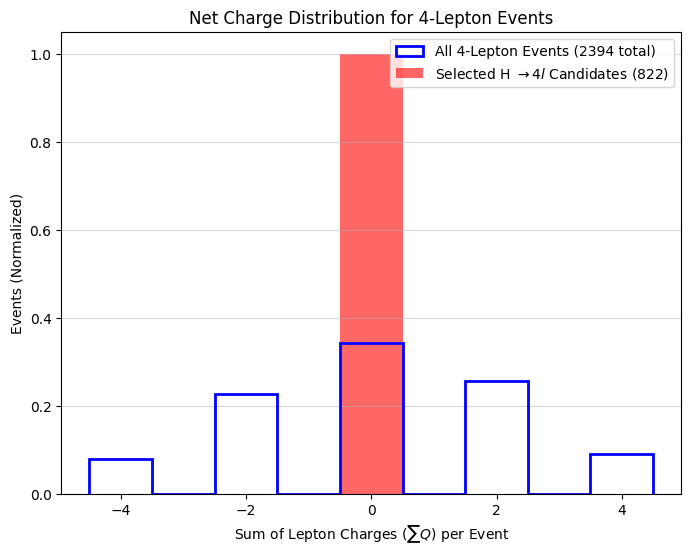

In [23]:
four_lepton_candidates_df, all_four_leptons_df = group_leptons_by_event_with_diagnostic_data(cleaned_leptons_df)

print("\n--- STATUS: Event selection complete. Ready for Z-boson pairing. ---")

# --- CORRECTED DISPLAY LOGIC ---
if not four_lepton_candidates_df.empty:
    print("\nPreview of H -> 4l candidate leptons:")
    
    # 1. Select the safe columns
    safe_columns_df = four_lepton_candidates_df[['event_id', 'pt', 'charge', 'flavor']].head(8).copy()
    
    # 2. Extract a safe, human-readable string representation of the Lorentz Vector
    # We use the .rho, .eta, .phi, .mass properties to create a tuple or string.
    
    # To be extremely safe, we will create a list of strings from the vector array
    lv_data = four_lepton_candidates_df['lv'].head(8).values
    
    # Map the vector objects to a simple string representation (e.g., "(pt=X, eta=Y)")
    lv_strings = [f"(pt={v.pt:.2f}, η={v.eta:.2f}, φ={v.phi:.2f})" for v in lv_data]
    
    # 3. Add the safe string representation as a new column
    safe_columns_df['lv_repr'] = lv_strings

    # 4. Print the safe DataFrame, excluding the toxic 'lv' column
    print(safe_columns_df) 

    plot_charge_diagnostics(all_four_leptons_df, four_lepton_candidates_df)
    
    # Note: Do NOT try to print four_lepton_candidates_df['lv'] directly.